# Assignment 1 - __M&M Factory QA__

- To calculate:

    - [ ] Color distribuition. Must warn if any color is missing
    
    - [ ] Average shape area in mm and organized by color
    
     
 A) Calibrate intrinsic paramenters and lens distortion of the camera. Show the intrinsic matrix and the lens distortion coeffiecients.
  

In [ ]:
%pip install opencv-python
%pip install matplotlib

Loading Image data/IntrinsicCalibration/calib_img 0.png


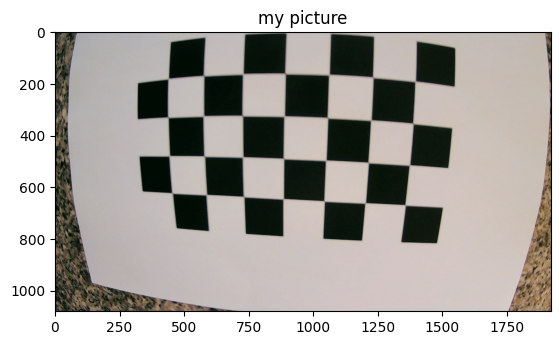

Ret is TRUE


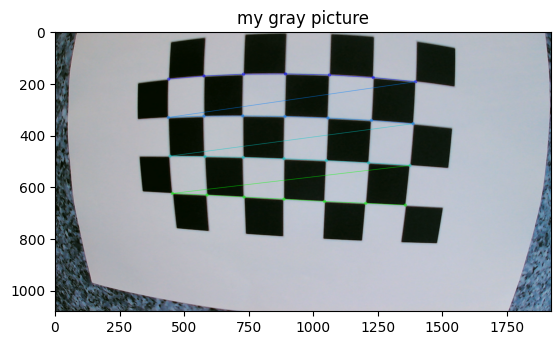

In [26]:
from matplotlib import pyplot as plt
import numpy as np
import cv2 as cv
import glob

grid_size = (7,4) # tuple that says the grid size

# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((grid_size[1]*grid_size[0],3), np.float32)
objp[:,:2] = np.mgrid[0:grid_size[0],0:grid_size[1]].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.

images = sorted(glob.glob('data/IntrinsicCalibration/calib_img 0.png'))

for fname in images:

    print(f"Loading Image {fname}")
    img = cv.imread(fname)
    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.title('my picture')
    plt.show()
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    # Find the chess board corners
    ret, corners = cv.findChessboardCornersSB(gray, grid_size, None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        print(f"Ret is TRUE")
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)
        # Draw and display the corners
        cv.drawChessboardCorners(img, grid_size, corners2, ret)
    plt.imshow(img)
    plt.title('my gray picture')
    plt.show()
    
    



In [36]:
import os

""" 
Renames the filenames within the same directory to be Unix friendly
(1) Changes spaces to hyphens
(2) Makes lowercase (not a Unix requirement, just looks better ;)
Usage:
python rename.py
"""

path="data/IntrinsicCalibration/"
filenames = os.listdir(path)
for filename in filenames:
    os.rename(path+filename, path+filename.replace(" ", "_"))